# Plotting dataslices for Run0166

###### Plotting_Run0166
- efiTEM_GB

In [ ]:
# DO NOT RUN THIS PART

In [ ]:
import os
import sys
import time

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])
print(file_name)

if file_name == "ipykernel_launcher":
    print("This is the Jupyter version.")
    print("Now MANUALLY run the next two cells!")
    print("STOP! This should not be in your code!!")
    exit(0)
    time.sleep(10)
    print("Testing if script has really stopped.")
else:
    print("This is the Atom version")

In [1]:
# RUN ONLY IN JUPYTER!!
# Start here (manual)

In [2]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"');

<IPython.core.display.Javascript object>

In [3]:
print(file_name)

2019-02-20_Plotting_Run0166.ipynb


In [4]:
file_name = file_name[:-6]
print(file_name)

is_Jupyter = True
print(is_Jupyter)

2019-02-20_Plotting_Run0166
True


In [5]:
# Same code for both ATOM & JUPYTER from now (Run all cells below now)

In [6]:
'''
Late Fusion Module (test) - Functional API
'''

# Multiple Inputs
import keras
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal, glorot_normal, Constant
from keras.utils import plot_model
from keras.models import Model
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers import Dense
from keras.layers import MaxoutDense
from keras.layers.merge import concatenate
from keras import regularizers
from keras import backend as K
#from keras.backend import switch
import pandas
import numpy
import sys
import os
from copy import deepcopy
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers.advanced_activations import ThresholdedReLU

#keras.backend.clear_session()
K.clear_session()

Using TensorFlow backend.


In [7]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

In [8]:
# Modify for ATOM use

In [9]:
if is_Jupyter == True:
    pass
else:
    # Gets the current file name. Useful for procedurally generating output/log files.
    file_name =  os.path.basename(sys.argv[0][:-3])

In [10]:
# Define neural network parameters
batch_size = 10
epochs = 100
L2_regularization = 5E-7

In [11]:
# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("../training_gen3_7D_nions0_flat_filter8.h5")
target_df = store['/output/efiTEM_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']

# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for later use
joined_dataFrame_original = deepcopy(joined_dataFrame)


# *************************************************************************** #
# Normalize data by standard deviation and mean-centering the data
# Standard configuration
joined_dataFrame['efiTEM_GB'] = (joined_dataFrame['efiTEM_GB'] - joined_dataFrame['efiTEM_GB'].mean()) / joined_dataFrame['efiTEM_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['q'] = (joined_dataFrame['q'] - joined_dataFrame['q'].mean()) / joined_dataFrame['q'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efiTEM_GB']

# Make a copy of shuffled_joined_dataFrame for later use
shuffled_joined_dataFrame_base = deepcopy(shuffled_joined_dataFrame)



# *************************************************************************** #
# Creates a pandas dataframe for the inputs (7D)
shuffled_clean_input_df_7D = shuffled_joined_dataFrame.drop('efiTEM_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df_7D.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df_7D.iloc[int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9)):]
# *************************************************************************** #


# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()

In [12]:
shuffled_clean_input_df_7D.describe(include='all')

,Ati,Ate,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,8.897386e-16,2.201926e-15,4.284476e-15,-1.092859e-14,-2.001794e-15,2.039425e-15,-4.401278e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.639065e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-7.898708e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,-9.507533e-02,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,5.997202e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,2.684107e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [13]:
# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_1 = shuffled_clean_input_df_7D.drop('Ate', axis=1)

In [14]:
shuffled_clean_input_df_1.describe(include='all')

,Ati,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,8.897386e-16,4.284476e-15,-1.092859e-14,-2.001794e-15,2.039425e-15,-4.401278e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [15]:
print(shuffled_clean_input_df_1.shape)

(6479137, 6)


In [16]:
shuffled_clean_input_df_2 = shuffled_clean_input_df_7D.drop('Ati', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('An', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('q', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('smag', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('x', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('Ti_Te', axis=1)

In [17]:
shuffled_clean_input_df_2.describe(include='all')

,Ate
count,6.479137e+06
mean,2.201926e-15
std,1.000000e+00
min,-1.639065e+00
25%,-7.898708e-01
50%,-9.507533e-02
75%,5.997202e-01
max,2.684107e+00


In [18]:
print(shuffled_clean_input_df_2.shape)

(6479137, 1)


In [19]:
# *************************************************************************** #
# Branch 1

# Creates training dataset (90% of total data) for inputs
x_train_1 = shuffled_clean_input_df_1.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_1 = shuffled_clean_input_df_1.iloc[int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9)):]
# *************************************************************************** #

In [20]:
# *************************************************************************** #
# Branch 2

# Creates training dataset (90% of total data) for inputs
x_train_2 = shuffled_clean_input_df_2.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_2 = shuffled_clean_input_df_2.iloc[int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9)):]
# *************************************************************************** #

# Load Model

In [21]:
from keras.models import load_model

In [22]:
new_model = load_model('../Saved-Networks/2019-02-20_Run0166.h5', custom_objects={'rmse': rmse})

#### Model information

In [23]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
6D_INPUTS (InputLayer)          (None, 6)            0                                            
__________________________________________________________________________________________________
hidden1_branch1 (Dense)         (None, 30)           210         6D_INPUTS[0][0]                  
__________________________________________________________________________________________________
hidden2_branch1 (Dense)         (None, 30)           930         hidden1_branch1[0][0]            
__________________________________________________________________________________________________
theta_branch1 (Dense)           (None, 1)            31          hidden2_branch1[0][0]            
__________________________________________________________________________________________________
hidden1_br

In [24]:
new_model.get_weights()

[array([[ 1.08331537e+00, -1.43798720e-02, -9.94820118e-01,
         -1.05204397e-29,  6.78858697e-01,  2.96786875e-01,
          2.74571776e+00,  1.52510071e+00, -3.08278769e-01,
         -2.32359886e+00,  7.71240890e-01,  1.05810569e-29,
          5.86725295e-01,  4.78018951e+00,  2.68804264e+00,
         -5.15848279e-01, -2.18913838e-01,  5.09752560e+00,
          7.06934631e-02,  8.06254670e-02, -2.63126040e+00,
          4.33627081e+00, -2.94720030e+00, -1.49454212e+00,
         -2.89823813e-03, -8.82209122e-01,  2.23255858e-01,
          2.83072531e-01,  2.65926862e+00, -3.40056515e+00],
        [ 4.92060572e-01,  7.41439834e-02,  1.24370742e+00,
         -1.05850163e-29, -3.47954303e-01, -1.79437029e+00,
         -2.77374244e+00, -3.47721052e+00, -2.64098549e+00,
          4.77888775e+00, -2.19148350e+00,  1.04896625e-29,
          7.49216199e-01, -1.96645629e+00,  2.37987638e+00,
          6.35622883e+00,  5.17378688e-01, -1.30259764e+00,
          3.82690454e+00, -1.30793023e+

In [25]:
new_model.optimizer

# Predictions (Global)

"Global" in this sense means that I've fed model.predict() with all the possible parameters. This gives a good overview of the overall performance of the network. This can be useful to spot large-scale phenomena like network overfitting but is not so great at looking at say individual data slices. This is done later.

***Nota Bene: all data here is NORMALIZED at this stage.***

In [26]:
y_test_np_array = y_test.values
print(y_test_np_array)
print(y_test_np_array.shape)

[-0.15051689 -0.15051689 -0.15051689 ... -0.15051689 -0.15051689
 -0.15051689]
(647914,)


In [27]:
x_test_np_array = x_test.values
print(x_test_np_array)

[[-1.63230031 -0.55827233 -1.90100118 ... -0.46979169 -0.9907529
   1.94482849]
 [-0.79279996 -1.02146933  0.1347799  ...  0.08246599  1.70406169
   0.75767614]
 [ 0.80988254 -0.78987083 -0.03486852 ...  1.73923903 -0.9907529
   1.94482849]
 ...
 [ 1.42042826 -0.09507533  0.64372517 ... -0.46979169 -0.16157921
  -0.88172461]
 [-1.0217546   0.59972017  0.30442833 ... -1.57430706  1.70406169
  -0.88172461]
 [-0.56384531  0.13652317  0.30442833 ...  1.73923903 -0.57616598
   0.29129499]]


In [28]:
x_test_1_np_array = x_test_1.values
x_test_2_np_array = x_test_2.values

In [29]:
print(x_test_1_np_array.shape)

(647914, 6)


In [30]:
print(x_test_2_np_array.shape)

(647914, 1)


In [31]:
print(x_test_np_array.shape)

(647914, 7)


In [32]:
predictions_global = new_model.predict([x_test_1_np_array, x_test_2_np_array], batch_size = 10, verbose=0)
print(type(predictions_global))

predictions_global = predictions_global.flatten()
print(predictions_global.shape)
print(type(predictions_global))

<class 'numpy.ndarray'>
(647914,)
<class 'numpy.ndarray'>


### Predictions (Global) review - De-Normalized

In [33]:
predictions_global_deNormalized = (predictions_global * joined_dataFrame_original['efiTEM_GB'].std()) + joined_dataFrame_original['efiTEM_GB'].mean()

In [34]:
y_test_deNormalized = (y_test * joined_dataFrame_original['efiTEM_GB'].std()) + joined_dataFrame_original['efiTEM_GB'].mean()

In [35]:
y_test_deNormalized_np_array = y_test_deNormalized.values

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

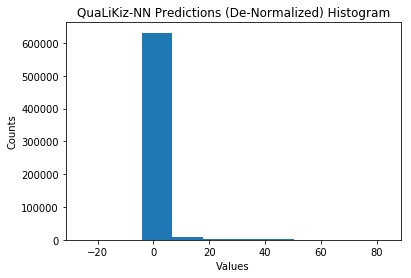

In [37]:
plt.hist(predictions_global_deNormalized)
plt.title('QuaLiKiz-NN Predictions (De-Normalized) Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

In [38]:
print(predictions_global.shape)

(647914,)


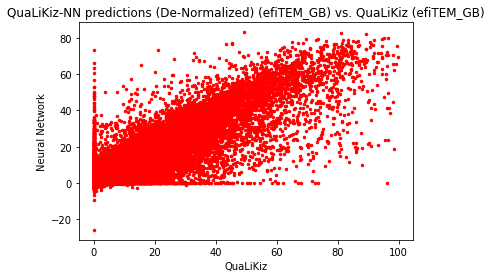

In [39]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.title('QuaLiKiz-NN predictions (De-Normalized) (efiTEM_GB) vs. QuaLiKiz (efiTEM_GB)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.show()

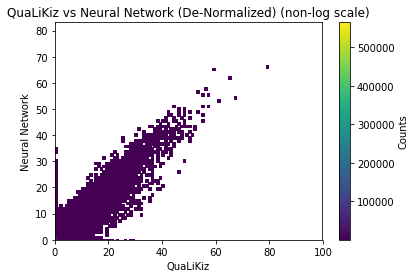

In [40]:
plt.hist2d(y_test_deNormalized_np_array, predictions_global_deNormalized, bins=100, cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (De-Normalized) (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

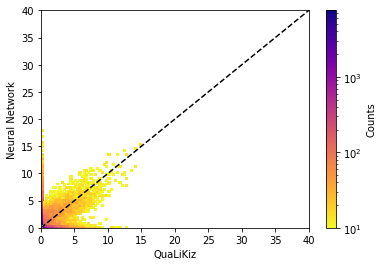

In [73]:
plt.hist2d(y_test_deNormalized_np_array, predictions_global_deNormalized, bins=300, cmin=10, cmax = 1e4, norm=LogNorm(), cmap='plasma_r')
plt.plot( [0,40],[0,40],'k--' )
#plt.title('QuaLiKiz vs Neural Network (De-Normalized) (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0, 40)
plt.xlim(0, 40)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
#plt.savefig('./2019-02-20_Run0166_DataSlicerPlot/QuaLiKiz-vs-NN.png', dpi = 100)
plt.show()

### Sigmas (De-Normalized)

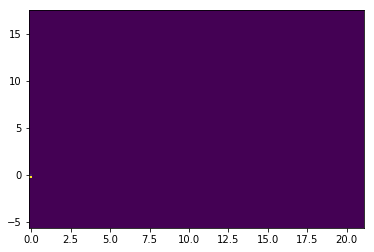

In [42]:
h = plt.hist2d(y_test_np_array, predictions_global,bins = 100)

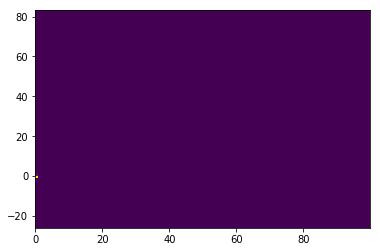

In [43]:
h_deNormalized = plt.hist2d(y_test_deNormalized_np_array, predictions_global_deNormalized,bins = 100)

In [44]:
sigmas_deNormalized = []
Qualikiz_deNormalized = y_test_deNormalized_np_array
for i in range(len(h[0])):
    sigmas_deNormalized.append(numpy.std(h_deNormalized[0][i] / numpy.max(h_deNormalized[0][i])))

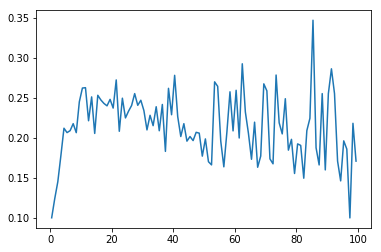

In [45]:
plt.plot((numpy.array(h_deNormalized[1][1:]) + numpy.array(h_deNormalized[1][:-1]))/2.,sigmas_deNormalized)
plt.show()

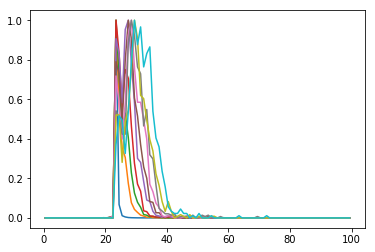

In [46]:
for i in range(10):
    plt.plot((h_deNormalized[1][1:] + h_deNormalized[1][:-1])/2., h_deNormalized[0][i]/numpy.max(h_deNormalized[0][i]) )

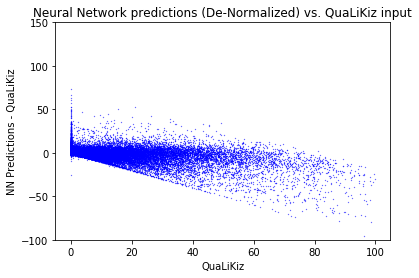

In [74]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.5)
plt.title('Neural Network predictions (De-Normalized) vs. QuaLiKiz input')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.ylim(-100, 150)
#plt.savefig('./2019-02-20_Run0166_DataSlicerPlot/Neural-Network-predictions-(De-Normalized)-vs-QuaLiKiz-input_ms0.5.png', dpi = 300)
plt.show()

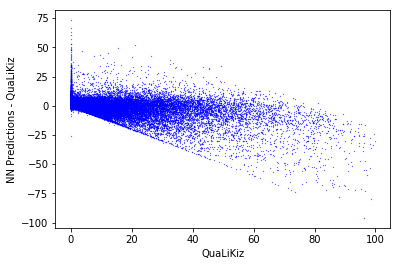

In [48]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.5)
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
#plt.savefig('./2019-02-10_Run0164_DataSlicerPlot/Neural-Network-predictions-(De-Normalized)-vs-QuaLiKiz-input_ms0.5.png', dpi = 300)
plt.show()

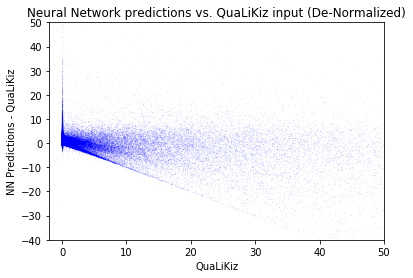

In [80]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.1, alpha=0.5)
plt.title('Neural Network predictions vs. QuaLiKiz input (De-Normalized)')
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
plt.ylim(-40, 50)
plt.xlim(-2, 50)
#plt.savefig('./2019-02-20_Run0166_DataSlicerPlot/Neural-Network-predictions-(De-Normalized)-vs-QuaLiKiz-input_ms0.1.png', dpi = 300)
plt.show()

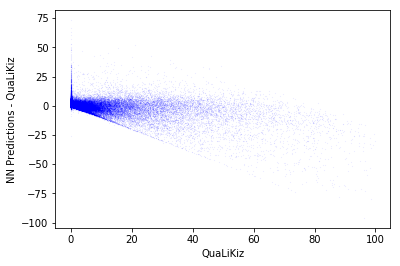

In [50]:
plt.plot(y_test_deNormalized_np_array, predictions_global_deNormalized - y_test_deNormalized_np_array, 'b.', ms = 0.1, alpha=0.5)
plt.xlabel('QuaLiKiz')
plt.ylabel('NN Predictions - QuaLiKiz')
#plt.savefig('./2019-02-10_Run0164_DataSlicerPlot/Neural-Network-predictions-(De-Normalized)-vs-QuaLiKiz-input_ms0.1.png', dpi = 300)
plt.show()

# Predictions (single Data Slice)

### Predictions - Initialise table to feed predictions

In [51]:
# table (Original values from input file unstable_training_gen2_7D_nions0_flat_filter7.h5)
# Hard-coded variables for the data slice

table = numpy.zeros((200,7))

table[:,0] = 5.75    # Ati
table[:,1] = numpy.linspace(2,14,200)   # Ate
table[:,2] = 3       # An
table[:,3] = 3       # qx
table[:,4] = 0.7     # smag
table[:,5] = 0.45    # x
table[:,6] = 1.33    # Ti_Te

table

array([[ 5.75      ,  2.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.06030151,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.12060302,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       ...,
       [ 5.75      , 13.87939698,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 13.93969849,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 14.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ]])

In [52]:
# Normalized table (inputs for model.predict())
table_normalized = numpy.zeros((200,7))

DataSlice_Ati = 5.75
DataSlice_Ate = numpy.linspace(2,14,200)
DataSlice_An = 3
DataSlice_q = 3
DataSlice_smag = 0.7
DataSlice_x = 0.45
DataSlice_Ti_Te = 1.33

# Normalize data by standard deviation and mean-centering the data
table_normalized[:,0] = (DataSlice_Ati - joined_dataFrame_original['Ati'].mean()) / joined_dataFrame_original['Ati'].std()
table_normalized[:,1] = (DataSlice_Ate - joined_dataFrame_original['Ate'].mean()) / joined_dataFrame_original['Ate'].std()
table_normalized[:,2] = (DataSlice_An - joined_dataFrame_original['An'].mean()) / joined_dataFrame_original['An'].std()
table_normalized[:,3] = (DataSlice_q - joined_dataFrame_original['q'].mean()) / joined_dataFrame_original['q'].std()
table_normalized[:,4] = (DataSlice_smag - joined_dataFrame_original['smag'].mean()) / joined_dataFrame_original['smag'].std()
table_normalized[:,5] = (DataSlice_x - joined_dataFrame_original['x'].mean()) / joined_dataFrame_original['x'].std()
table_normalized[:,6] = (DataSlice_Ti_Te - joined_dataFrame_original['Ti_Te'].mean()) / joined_dataFrame_original['Ti_Te'].std()

In [53]:
table_normalized

array([[ 0.12301861, -1.02146933,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492],
       [ 0.12301861, -1.00284834,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492],
       [ 0.12301861, -0.98422736,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492],
       ...,
       [ 0.12301861,  2.64686471,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492],
       [ 0.12301861,  2.66548569,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492],
       [ 0.12301861,  2.68410668,  0.8133736 , ..., -0.635469  ,
        -0.16157917,  0.29129492]])

In [54]:
# Normalized table (inputs for model.predict())
table_branch1_normalized = numpy.zeros((200,6))

DataSlice_Ati = 5.75
#DataSlice_Ate = numpy.linspace(2,14,200)
DataSlice_An = 3
DataSlice_q = 3
DataSlice_smag = 0.7
DataSlice_x = 0.45
DataSlice_Ti_Te = 1.33

# Normalize data by standard deviation and mean-centering the data
table_branch1_normalized[:,0] = (DataSlice_Ati - joined_dataFrame_original['Ati'].mean()) / joined_dataFrame_original['Ati'].std()
#table_normalized[:,1] = (DataSlice_Ate - joined_dataFrame_original['Ate'].mean()) / joined_dataFrame_original['Ate'].std()
table_branch1_normalized[:,1] = (DataSlice_An - joined_dataFrame_original['An'].mean()) / joined_dataFrame_original['An'].std()
table_branch1_normalized[:,2] = (DataSlice_q - joined_dataFrame_original['q'].mean()) / joined_dataFrame_original['q'].std()
table_branch1_normalized[:,3] = (DataSlice_smag - joined_dataFrame_original['smag'].mean()) / joined_dataFrame_original['smag'].std()
table_branch1_normalized[:,4] = (DataSlice_x - joined_dataFrame_original['x'].mean()) / joined_dataFrame_original['x'].std()
table_branch1_normalized[:,5] = (DataSlice_Ti_Te - joined_dataFrame_original['Ti_Te'].mean()) / joined_dataFrame_original['Ti_Te'].std()

In [55]:
# Normalized table (inputs for model.predict())
table_branch2_normalized = numpy.zeros((200,1))

DataSlice_Ate = numpy.linspace(2,14,200)

# Normalize data by standard deviation and mean-centering the data
table_branch2_normalized[:,0] = (DataSlice_Ate - joined_dataFrame_original['Ate'].mean()) / joined_dataFrame_original['Ate'].std()

In [56]:
predictions = new_model.predict([table_branch1_normalized] + [table_branch2_normalized], batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))

<class 'numpy.ndarray'>
(200,)
<class 'numpy.ndarray'>


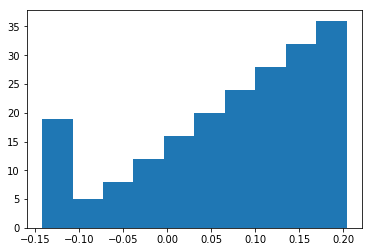

In [57]:
plt.hist(predictions)
plt.show()

# Masks

These are used to rapidly select which parameters to look at (for a given data slice).

#### Ate

In [58]:
Ate_mask1 = joined_dataFrame_original.Ate == 2
Ate_mask2 = joined_dataFrame_original.Ate == 2.75
Ate_mask3 = joined_dataFrame_original.Ate == 3.5
Ate_mask4 = joined_dataFrame_original.Ate == 4.25
Ate_mask5 = joined_dataFrame_original.Ate == 5
Ate_mask6 = joined_dataFrame_original.Ate == 5.75
Ate_mask7 = joined_dataFrame_original.Ate == 6.5
Ate_mask8 = joined_dataFrame_original.Ate == 7.25
Ate_mask9 = joined_dataFrame_original.Ate == 8
Ate_mask10 = joined_dataFrame_original.Ate == 10
Ate_mask11 = joined_dataFrame_original.Ate == 14

Ate_anti_mask1 = joined_dataFrame_original.Ate != 2
Ate_anti_mask2 = joined_dataFrame_original.Ate != 2.75
Ate_anti_mask3 = joined_dataFrame_original.Ate != 3.5
Ate_anti_mask4 = joined_dataFrame_original.Ate != 4.25
Ate_anti_mask5 = joined_dataFrame_original.Ate != 5
Ate_anti_mask6 = joined_dataFrame_original.Ate != 5.75
Ate_anti_mask7 = joined_dataFrame_original.Ate != 6.5
Ate_anti_mask8 = joined_dataFrame_original.Ate != 7.25
Ate_anti_mask9 = joined_dataFrame_original.Ate != 8
Ate_anti_mask10 = joined_dataFrame_original.Ate != 10
Ate_anti_mask11 = joined_dataFrame_original.Ate != 14

#### An

In [59]:
An_mask1 = joined_dataFrame_original.An == -5
An_mask2 = joined_dataFrame_original.An == -3
An_mask3 = joined_dataFrame_original.An == -1
An_mask4 = numpy.array(joined_dataFrame_original.An <= 1.1e-14) * numpy.array(joined_dataFrame_original.An >= 9E-15)
An_mask5 = joined_dataFrame_original.An == 0.5
An_mask6 = joined_dataFrame_original.An == 1.0
An_mask7 = joined_dataFrame_original.An == 1.5
An_mask8 = joined_dataFrame_original.An == 2.0
An_mask9 = joined_dataFrame_original.An == 2.5
An_mask10 = joined_dataFrame_original.An == 3.0
An_mask11 = joined_dataFrame_original.An == 4.0
An_mask12 = joined_dataFrame_original.An == 6.0

An_anti_mask1 = joined_dataFrame_original.An != -5
An_anti_mask2 = joined_dataFrame_original.An != -3
An_anti_mask3 = joined_dataFrame_original.An != -1
An_anti_mask4 = numpy.array(joined_dataFrame_original.An >= 1.1e-14) * numpy.array(joined_dataFrame_original.An <= 9E-15)
An_anti_mask5 = joined_dataFrame_original.An != 0.5
An_anti_mask6 = joined_dataFrame_original.An != 1.0
An_anti_mask7 = joined_dataFrame_original.An != 1.5
An_anti_mask8 = joined_dataFrame_original.An != 2.0
An_anti_mask9 = joined_dataFrame_original.An != 2.5
An_anti_mask10 = joined_dataFrame_original.An != 3.0
An_anti_mask11 = joined_dataFrame_original.An != 4.0
An_anti_mask12 = joined_dataFrame_original.An != 6.0

#### Ati

In [60]:
Ati_mask1 = numpy.array(joined_dataFrame_original.Ati <= 1.1e-14) * numpy.array(joined_dataFrame_original.Ati >= 9E-15)
Ati_mask2 = joined_dataFrame_original.Ati == 2
Ati_mask3 = joined_dataFrame_original.Ati == 2.75
Ati_mask4 = joined_dataFrame_original.Ati == 3.5
Ati_mask5 = joined_dataFrame_original.Ati == 4.25
Ati_mask6 = joined_dataFrame_original.Ati == 5
Ati_mask7 = joined_dataFrame_original.Ati == 5.75
Ati_mask8 = joined_dataFrame_original.Ati == 6.5
Ati_mask9 = joined_dataFrame_original.Ati == 7.25
Ati_mask10 = joined_dataFrame_original.Ati == 8
Ati_mask11 = joined_dataFrame_original.Ati == 10
Ati_mask12 = joined_dataFrame_original.Ati == 14

#### qx

In [61]:
q_mask0 = numpy.array(joined_dataFrame_original.q <= 0.67) * numpy.array(joined_dataFrame_original.q >= 0.65)  #0.66
q_mask1 = joined_dataFrame_original.q == 1.0
q_mask2 = joined_dataFrame_original.q == 1.5
q_mask3 = joined_dataFrame_original.q == 2.0
q_mask4 = joined_dataFrame_original.q == 2.5
q_mask5 = joined_dataFrame_original.q == 3.0
q_mask6 = joined_dataFrame_original.q == 4.0
q_mask7 = joined_dataFrame_original.q == 5.0
q_mask8 = joined_dataFrame_original.q == 10.00
q_mask9 = joined_dataFrame_original.q == 15.00

q_anti_mask0 = numpy.array(joined_dataFrame_original.q >= 0.67) * numpy.array(joined_dataFrame_original.q <= 0.65)  #0.66
q_anti_mask1 = joined_dataFrame_original.q != 1.0
q_anti_mask2 = joined_dataFrame_original.q != 1.5
q_anti_mask3 = joined_dataFrame_original.q != 2.0
q_anti_mask4 = joined_dataFrame_original.q != 2.5
q_anti_mask5 = joined_dataFrame_original.q != 3.0
q_anti_mask6 = joined_dataFrame_original.q != 4.0
q_anti_mask7 = joined_dataFrame_original.q != 5.0
q_anti_mask8 = joined_dataFrame_original.q != 10.00
q_anti_mask9 = joined_dataFrame_original.q != 15.00

#### smag

In [62]:
smag_mask1 = joined_dataFrame_original.smag == -1.0
smag_mask2 = numpy.array(joined_dataFrame_original.smag <= 0.11) * numpy.array(joined_dataFrame_original.smag >= 0.09)   # 0.1
smag_mask3 = numpy.array(joined_dataFrame_original.smag <= 0.41) * numpy.array(joined_dataFrame_original.smag >= 0.39)   # 0.4
smag_mask4 = numpy.array(joined_dataFrame_original.smag <= 0.71) * numpy.array(joined_dataFrame_original.smag >= 0.68)   # 0.7
smag_mask5 = joined_dataFrame_original.smag == 1
smag_mask6 = joined_dataFrame_original.smag == 1.5
smag_mask7 = joined_dataFrame_original.smag == 2.0
smag_mask8 = joined_dataFrame_original.smag == 2.75
smag_mask9 = joined_dataFrame_original.smag == 3.5
smag_mask10 = joined_dataFrame_original.smag == 5.0

smag_anti_mask1 = joined_dataFrame_original.smag != -1.0
smag_anti_mask2 = numpy.array(joined_dataFrame_original.smag >= 0.11) * numpy.array(joined_dataFrame_original.smag <= 0.09)   # 0.1
smag_anti_mask3 = numpy.array(joined_dataFrame_original.smag >= 0.41) * numpy.array(joined_dataFrame_original.smag <= 0.39)   # 0.4
smag_anti_mask4 = numpy.array(joined_dataFrame_original.smag >= 0.71) * numpy.array(joined_dataFrame_original.smag <= 0.68)   # 0.7
smag_anti_mask5 = joined_dataFrame_original.smag != 1
smag_anti_mask6 = joined_dataFrame_original.smag != 1.5
smag_anti_mask7 = joined_dataFrame_original.smag != 2.0
smag_anti_mask8 = joined_dataFrame_original.smag != 2.75
smag_anti_mask9 = joined_dataFrame_original.smag != 3.5
smag_anti_mask10 = joined_dataFrame_original.smag != 5.0

#### x

In [63]:
x_mask1 = numpy.array(joined_dataFrame_original.x <= 0.10) * numpy.array(joined_dataFrame_original.x >= 0.08)   # 0.09
x_mask2 = numpy.array(joined_dataFrame_original.x <= 0.22) * numpy.array(joined_dataFrame_original.x >= 0.20)   # 0.21
x_mask3 = numpy.array(joined_dataFrame_original.x <= 0.34) * numpy.array(joined_dataFrame_original.x >= 0.32)   # 0.33
x_mask4 = numpy.array(joined_dataFrame_original.x <= 0.46) * numpy.array(joined_dataFrame_original.x >= 0.44)   # 0.45
x_mask5 = numpy.array(joined_dataFrame_original.x <= 0.58) * numpy.array(joined_dataFrame_original.x >= 0.56)   # 0.57
x_mask6 = numpy.array(joined_dataFrame_original.x <= 0.70) * numpy.array(joined_dataFrame_original.x >= 0.68)   # 0.69
x_mask7 = numpy.array(joined_dataFrame_original.x <= 0.85) * numpy.array(joined_dataFrame_original.x >= 0.83)   # 0.84
x_mask8 = numpy.array(joined_dataFrame_original.x <= 1.00) * numpy.array(joined_dataFrame_original.x >= 0.98)   # 0.99
x_mask = {0.09: x_mask1}

x_anti_mask1 = numpy.array(joined_dataFrame_original.x >= 0.10) * numpy.array(joined_dataFrame_original.x <= 0.08)   # 0.09
x_anti_mask2 = numpy.array(joined_dataFrame_original.x >= 0.22) * numpy.array(joined_dataFrame_original.x <= 0.20)   # 0.21
x_anti_mask3 = numpy.array(joined_dataFrame_original.x >= 0.34) * numpy.array(joined_dataFrame_original.x <= 0.32)   # 0.33
x_anti_mask4 = numpy.array(joined_dataFrame_original.x >= 0.46) * numpy.array(joined_dataFrame_original.x <= 0.44)   # 0.45
x_anti_mask5 = numpy.array(joined_dataFrame_original.x >= 0.58) * numpy.array(joined_dataFrame_original.x <= 0.56)   # 0.57
x_anti_mask6 = numpy.array(joined_dataFrame_original.x >= 0.70) * numpy.array(joined_dataFrame_original.x <= 0.68)   # 0.69
x_anti_mask7 = numpy.array(joined_dataFrame_original.x >= 0.85) * numpy.array(joined_dataFrame_original.x <= 0.83)   # 0.84
x_anti_mask8 = numpy.array(joined_dataFrame_original.x >= 1.00) * numpy.array(joined_dataFrame_original.x <= 0.98)   # 0.99

#### Ti_Te

In [64]:
Ti_Te_mask1 = joined_dataFrame_original.Ti_Te == 0.25
Ti_Te_mask2 = joined_dataFrame_original.Ti_Te == 0.5
Ti_Te_mask3 = joined_dataFrame_original.Ti_Te == 0.75
Ti_Te_mask4 = joined_dataFrame_original.Ti_Te == 1
Ti_Te_mask5 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.34) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.32)   # 1.33
Ti_Te_mask6 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.67) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.65)   # 1.66
Ti_Te_mask7 = joined_dataFrame_original.Ti_Te == 2.50

# Plots

## Slice 1

In [65]:
'''
{'An': 3,
'Ati': 5.75,
'Ti_Te': 1.33,
'q': 3,
'smag': 0.7,
'x': 0.45}
'''
newDF = joined_dataFrame[An_mask10 & Ati_mask7 & q_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
newDF_Mk2 = joined_dataFrame_original[An_mask10 & Ati_mask7 & q_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
print(newDF)
print(type(newDF))

print(newDF_Mk2)
print(type(newDF_Mk2))

          efiTEM_GB       Ati       Ate        An         q      smag  \
29753959  -0.150517  0.123019 -1.021469  0.813374 -0.279168 -0.635469   
30560359  -0.150517  0.123019 -0.558272  0.813374 -0.279168 -0.635469   
30963559  -0.150517  0.123019 -0.326674  0.813374 -0.279168 -0.635469   
31366759  -0.150517  0.123019 -0.095075  0.813374 -0.279168 -0.635469   
32576359   0.517105  0.123019  0.599720  0.813374 -0.279168 -0.635469   

                 x     Ti_Te  
29753959 -0.161579  0.291295  
30560359 -0.161579  0.291295  
30963559 -0.161579  0.291295  
31366759 -0.161579  0.291295  
32576359 -0.161579  0.291295  
<class 'pandas.core.frame.DataFrame'>
          efiTEM_GB   Ati   Ate   An    q  smag     x  Ti_Te
29753959   0.000000  5.75  2.00  3.0  3.0   0.7  0.45   1.33
30560359   0.000000  5.75  3.50  3.0  3.0   0.7  0.45   1.33
30963559   0.000000  5.75  4.25  3.0  3.0   0.7  0.45   1.33
31366759   0.000000  5.75  5.00  3.0  3.0   0.7  0.45   1.33
32576359   3.138099  5.75  7.25 

In [66]:
efeETG_DF = newDF['efiTEM_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)

[-0.15051689 -0.15051689 -0.15051689 -0.15051689  0.51710517]
[-1.02146933 -0.55827233 -0.32667383 -0.09507533  0.59972017]


In [67]:
efeETG_DF_Mk2 = newDF_Mk2['efiTEM_GB']
efeETG_DF_Mk2_np_array = efeETG_DF_Mk2.values
print(efeETG_DF_Mk2_np_array)

Ate_DF_Mk2 = newDF_Mk2['Ate']
Ate_DF_Mk2_np_array = Ate_DF_Mk2.values
print(Ate_DF_Mk2_np_array)

[0.       0.       0.       0.       3.138099]
[2.   3.5  4.25 5.   7.25]


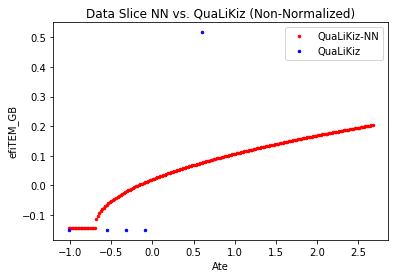

In [68]:
efeETG_DF = newDF['efiTEM_GB']
Ate_DF = newDF['Ate']
plt.plot(table_normalized[:,1], predictions, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.title('Data Slice NN vs. QuaLiKiz (Non-Normalized)')
plt.xlabel('Ate')
plt.ylabel('efiTEM_GB')
plt.legend()
plt.show()

In [69]:
predictions_deNormalized = (predictions * joined_dataFrame_original['efiTEM_GB'].std()) + joined_dataFrame_original['efiTEM_GB'].mean()
print(predictions_deNormalized.shape)

(200,)


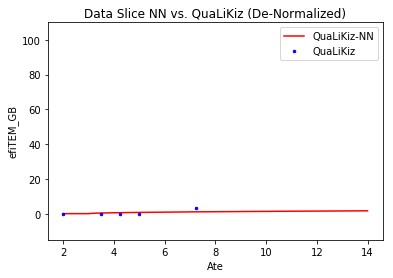

In [70]:
plt.plot(table[:,1], predictions_deNormalized, 'r-', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_Mk2_np_array, efeETG_DF_Mk2_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.title('Data Slice NN vs. QuaLiKiz (De-Normalized)')
plt.ylim(-15, 110)
plt.xlabel('Ate')
plt.ylabel('efiTEM_GB')
plt.legend()
# plt.savefig('./2018-07-19_Plotting-Clean-Run0054/NN_Predictions.png', dpi = 100)
plt.show()

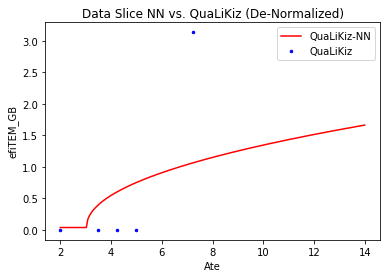

In [71]:
plt.plot(table[:,1], predictions_deNormalized, 'r-', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_Mk2_np_array, efeETG_DF_Mk2_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.title('Data Slice NN vs. QuaLiKiz (De-Normalized)')
#plt.ylim(-15, 110)
plt.xlabel('Ate')
plt.ylabel('efiTEM_GB')
plt.legend()
# plt.savefig('./2018-07-19_Plotting-Clean-Run0054/NN_Predictions.png', dpi = 100)
plt.show()

## Slice 2

In [72]:
# TODO